# Run this section to setup script

In [1]:
# Imports
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
import numpy as np
from scipy import ndimage as ndi
import pandas as pd
import seaborn as sns
import glob

from skimage.io import imread, imsave
from skimage.exposure import histogram
from skimage.filters import sobel, threshold_otsu, threshold_multiotsu
from skimage.segmentation import watershed, expand_labels, clear_border
from skimage.measure import label, regionprops, regionprops_table
from skimage.morphology import closing, square
from skimage.color import label2rgb, rgb2gray
from skimage.draw import circle_perimeter
from skimage.feature import peak_local_max

# Core segmentation founction (uses blue channel)
def segment_from_image(image_blue,
                       background_bound,
                       foreground_bound,
                       min_distance):
    
    # Sobel edge detection
    edges = sobel(image_blue)
    edges[edges < 0.01] = 0
    edges[edges > 0.1] = 0.1
    # Thresholding
    markers = np.zeros_like(image_blue)
    foreground, background = 1, 2
    markers[image_blue < background_bound] = background
    markers[image_blue > foreground_bound] = foreground
    # 1st watershed
    ws = watershed(edges, markers)
    # Distance transform to get local maxima
    to_dist = (ws == 1)
    distance = ndi.distance_transform_edt(to_dist)
    coords = peak_local_max(ndi.distance_transform_edt(to_dist), min_distance = min_distance,
                            footprint=np.ones((3, 3)),
                            labels=to_dist)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    # 2nd watershed
    ws2 = watershed(edges, markers, mask=to_dist)
    # Label
    seg1 = label(ws2)
    return seg1

In [2]:
# Segments from file, calls above segmentation function, returns table of parameters
def segmented_parameters_from_file(file_to_segment,
                                   min_distance=80):
    # Read file
    image = imread(fname = file_to_segment)
    # Use blue channel to segment
    image[:,:,0] = 0
    image[:,:,1] = 0
    image_blue = rgb2gray(image)
    image_gray = rgb2gray(imread(fname = file_to_segment))
    # threshold
    thresholds = threshold_multiotsu(image_blue)
    threshold = threshold_otsu(image_blue)
    
    # Segment image
    seg1 = segment_from_image(image_blue,
                              background_bound=threshold,
                              foreground_bound=thresholds[1],
                              min_distance=min_distance)
    
    to_return = pd.DataFrame(regionprops_table(seg1, intensity_image = image_gray, properties=('intensity_image', 'image', 'mean_intensity', 'area', 'convex_area', 'solidity', 'eccentricity')))
    to_return["intensity_image_flat"] = to_return["intensity_image"].map(lambda x: np.array([a for b in x for a in b]))
    to_return["image_flat"] = to_return["image"].map(lambda x: np.array([a for b in x for a in b]))
    to_return["intensities"] = to_return.apply(lambda x: x["intensity_image_flat"][x["image_flat"]], axis=1)
    to_return["var"] = to_return["intensities"].map(lambda x: x.var())
    to_return["fano"] = to_return["var"] / to_return["mean_intensity"]
    to_return["file_name"] = pd.Series([file_to_segment.split("\\")[1] for i in range(len(to_return))])
    return to_return[["mean_intensity", "area", "solidity", "eccentricity", "var", "fano", "file_name"]]

# Segments from file, calls above segmentation function, returns color image
def segmented_image_from_file(file_to_segment,
                              min_distance=80):
    # Read file
    image = imread(fname = file_to_segment)
    image[:,:,0] = 0
    image[:,:,1] = 0
    image_gray = rgb2gray(image)
    # threshold
    thresholds = threshold_multiotsu(image_gray)
    threshold = threshold_otsu(image_gray)
    

    # Segment image
    seg1 = segment_from_image(image_gray,
                              background_bound=threshold,
                              foreground_bound=thresholds[1],
                              min_distance=min_distance)
    
    # Color labelled image
    color1 = label2rgb(seg1, image=image_gray, bg_label=0)
    
    return seg1, color1

# Run this section to define image directories and analyse the images

In [4]:
# Files and categories defined here
dir_images = ""
image_subsets = ["Sieved GP32 E0 15% coating",]

In [5]:
# Segment all files, get parameters
foo = {i: [segmented_parameters_from_file(j) for j in glob.glob(dir_images + i + "/*.bmp") if "_segmented.bmp" not in j] for i in image_subsets}
to_plot = pd.concat([pd.concat(foo[i]).assign(condition = i) for i in foo])

# Run this section to save the data to a tsv file

In [6]:
# Save parameters for segments > 8000 in area
to_plot[to_plot["area"] > 8000].to_csv("segmented_all_conditions_parameters.tsv", sep = "\t")

# Run this section to plot and save images

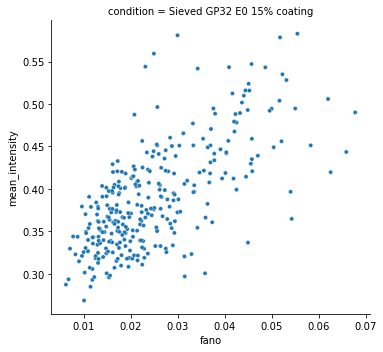

In [7]:
# Plot area against fano
g = sns.FacetGrid(to_plot[to_plot["area"] > 8000], col="condition", height=5, col_wrap=2)
g.map_dataframe(sns.scatterplot, x="fano", y="mean_intensity", size = 1)
g.savefig("fano_against_intensity.png")

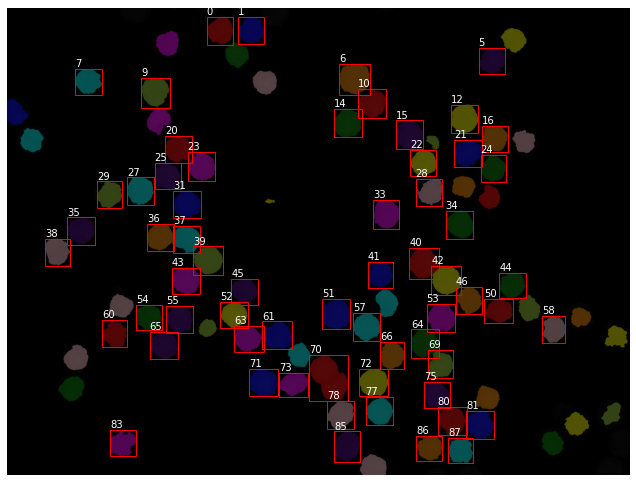

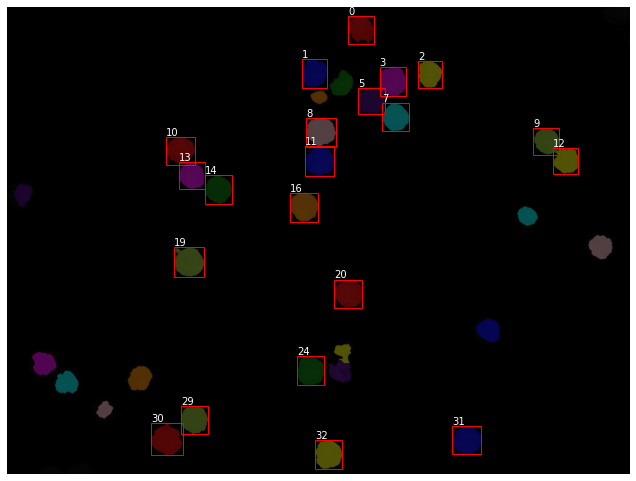

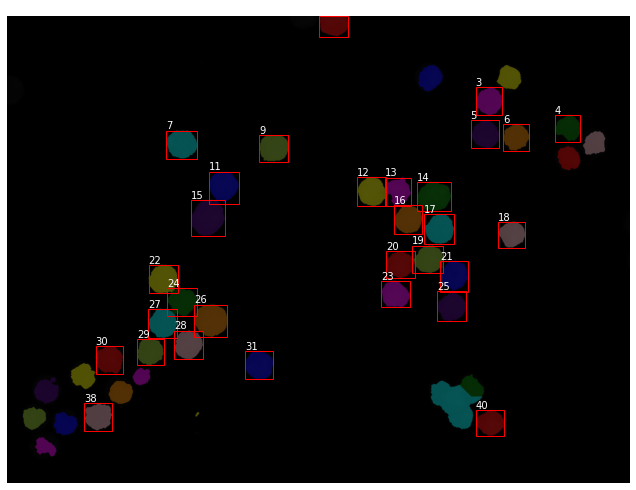

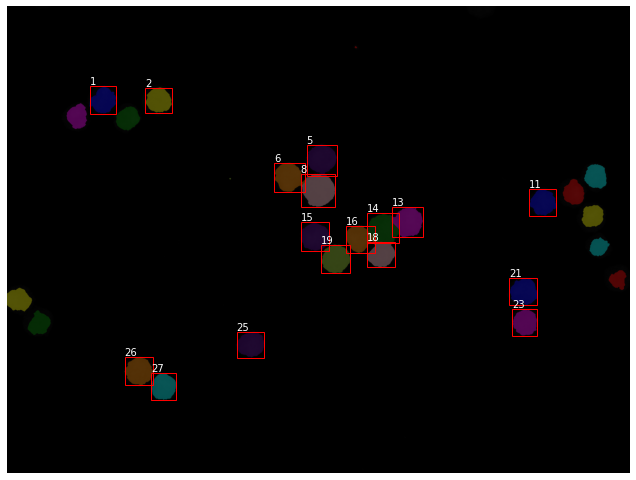

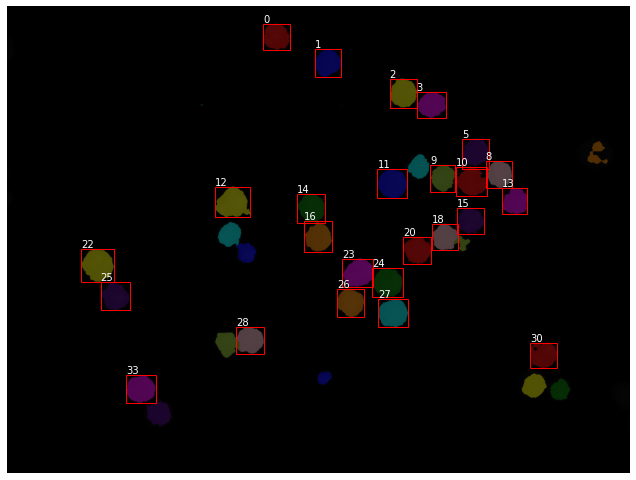

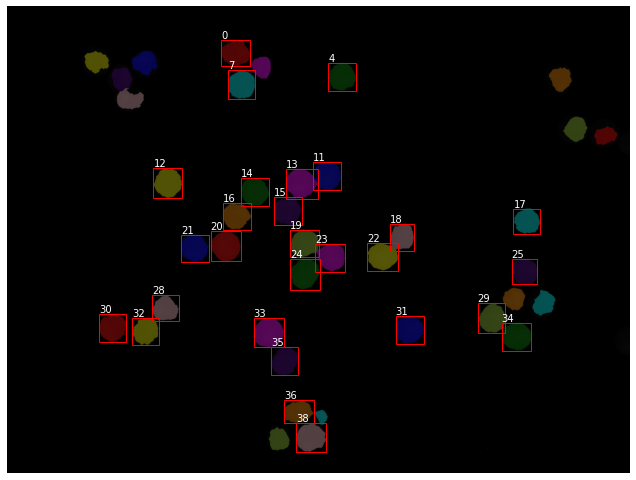

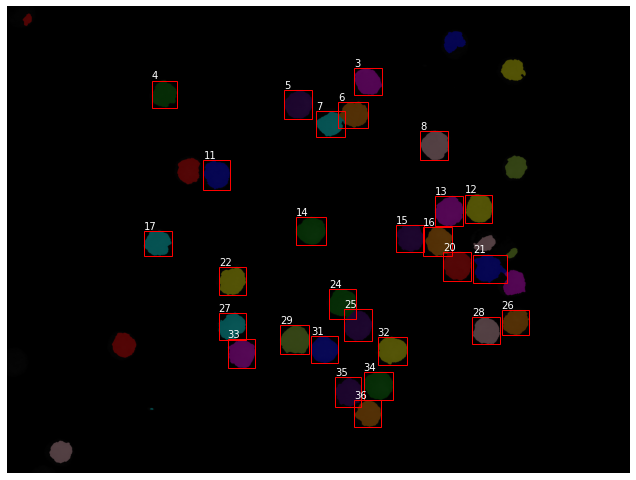

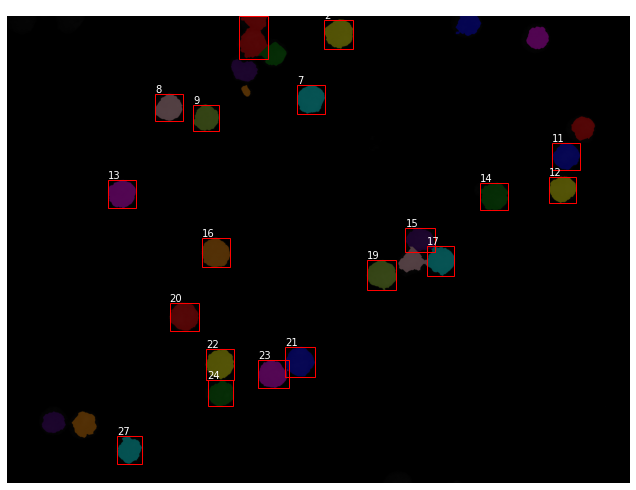

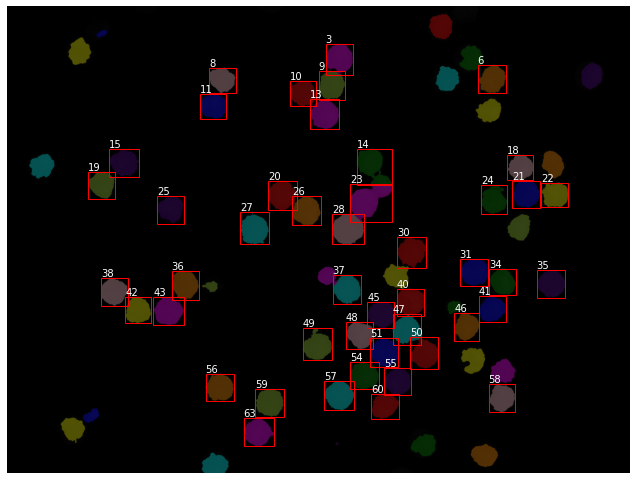

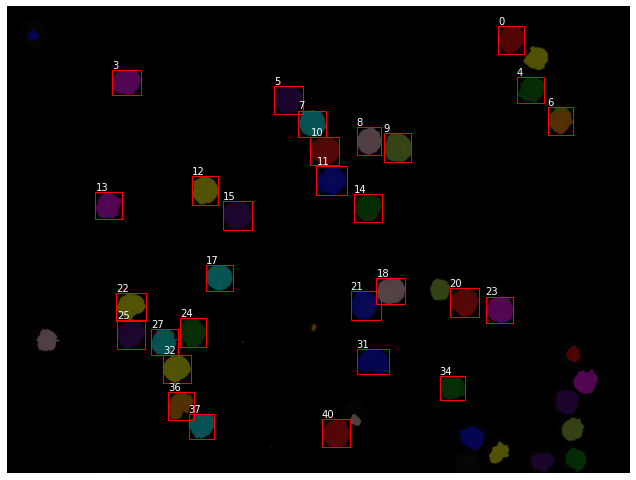

In [8]:
dpi = 300
# Segment files, output images
for i in image_subsets:
    for j in glob.glob(dir_images + i + "/*.bmp"):
        if "_segmented.bmp" not in j:
            seg1, color_labelled = segmented_image_from_file(j)
            height, width, depth = color_labelled.shape
            figsize = width / float(dpi), height / float(dpi)
            fig = plt.figure(figsize=figsize)
            ax = fig.add_axes([0, 0, 1, 1])
            ax.imshow(color_labelled)
            ax.axis("off")
            for region in regionprops(seg1):
                if (region.area > 8000) and (region.area < 20000):
                    minr, minc, maxr, maxc = region.bbox
                    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                              fill=False, edgecolor='red', linewidth=1)
                    ax.add_patch(rect)
                    ax.annotate(region.label-1, (minc, minr), ha = "left", va = "bottom", color = "white")
            plt.savefig(j[:-4] + "_segmented.tif", dpi = dpi)